In [17]:
import numpy as np
# import * from pr2_utils
import matplotlib.pyplot as plt
from scipy import signal
import transforms3d
from tqdm import trange, tqdm
import pr2_utils

In [2]:
dataset = 20

with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamsp = data["time_stamps"]  # acquisition times of the lidar scans 0.5 30

with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # Accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images


# Functions

In [7]:
SIGMA_V = 0.1
SIGMA_W = 0.01
MAP_RESOLUTION = 0.05

In [8]:
def show_lidar(ranges,angles):
    # angles = np.arange(-135,135.25,0.25)*np.pi/180.0
    # ranges = np.load("test_ranges.npy")
    plt.figure()
    ax = plt.subplot(111, projection='polar')
    ax.plot(angles, ranges)
    ax.set_rmax(10)
    ax.set_rticks([0.5, 1, 1.5, 2])  # fewer radial ticks
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.grid(True)
    ax.set_title("Lidar scan data", va='bottom')
    plt.show()

    
def generate_MAP(map_range=30,MAP_RESOLUTION=MAP_RESOLUTION):
    MAP = {}
    MAP['res']   = MAP_RESOLUTION #meters
    MAP['xmin']  = -map_range  #meters
    MAP['ymin']  = -map_range
    MAP['xmax']  =  map_range
    MAP['ymax']  =  map_range
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64) #DATA TYPE: char or int8
    return MAP

def thresh_lidar(ranges,angles):
    indValid = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[indValid]
    angles = angles[indValid]
    return ranges,angles

def lidar_polar2cart(ranges,angles):
    # xy position in the sensor frame
    xs0 = ranges*np.cos(angles)
    ys0 = ranges*np.sin(angles)

    # convert position in the map frame here 
    Y = np.stack((xs0,ys0))
    return Y

def lidar_cart2cell(xs0,ys0,MAP):
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    return(np.stack((xis,yis)))


def lidar_polar2cell(ranges,angles,MAP):
    xs0 = ranges*np.cos(angles)
    ys0 = ranges*np.sin(angles)

    # convert position in the map frame here 
    # Y = np.stack((xs0,ys0))

    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    return(np.stack((xis,yis)))

def clean_indices(xis,yis,MAP):
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    return(indGood)

def rotationMatrix(theta):
    return(np.array([[np.cos(theta),-np.sin(theta),0],
                     [np.sin(theta),np.cos(theta),0],
                     [0,0,1]]))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_map(m):
    return np.exp(m) / (1 + np.exp(m))


In [9]:
LIDAR_ANGLES = np.arange(lidar_angle_min,lidar_angle_max+(lidar_angle_increment*0.01),lidar_angle_increment)
MAP = generate_MAP()

# Data Ingestion

## Wheel Encoders

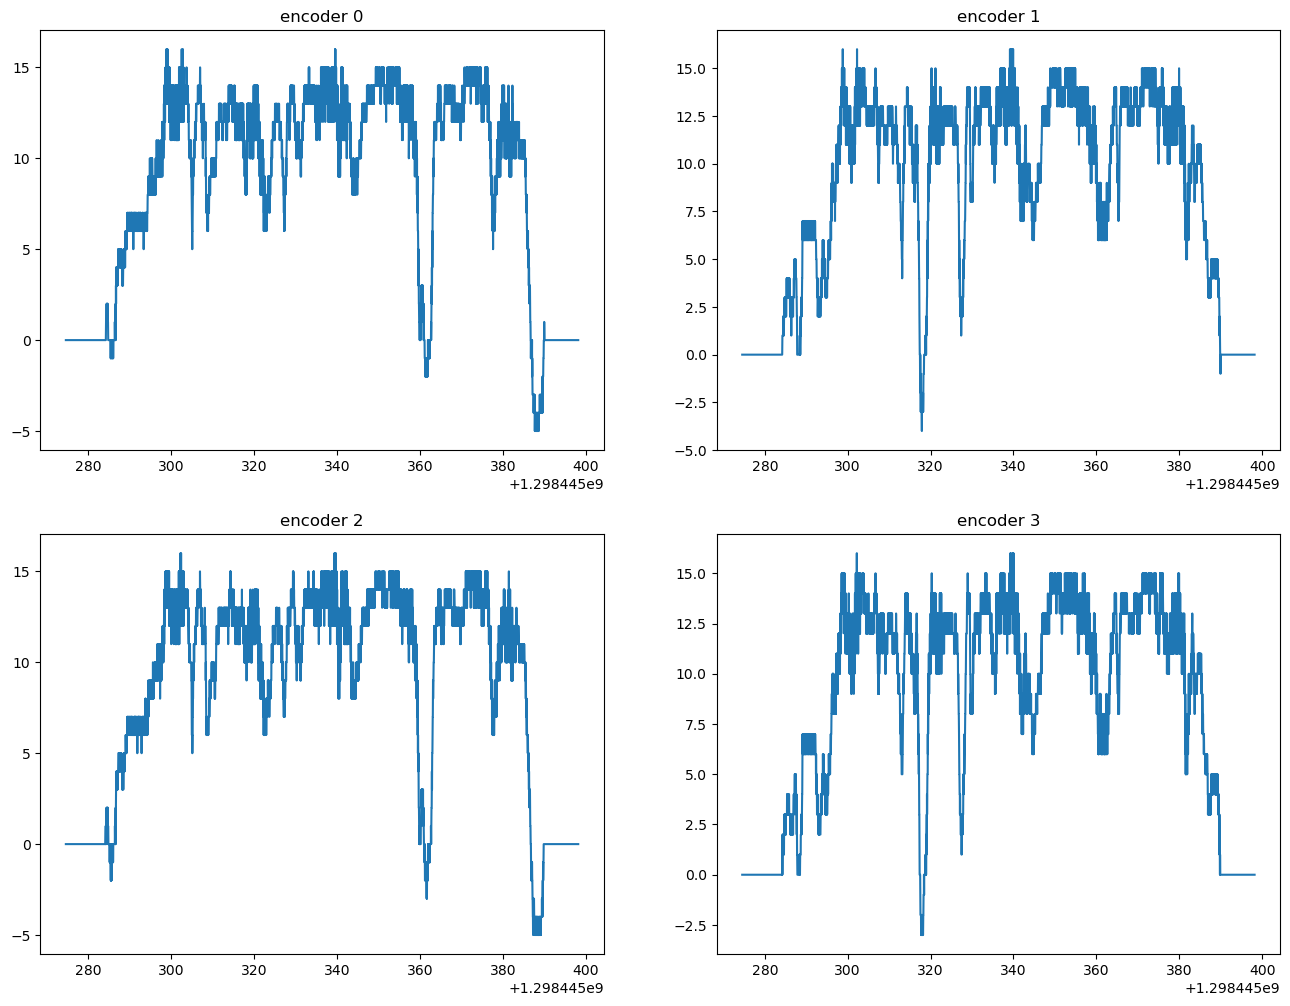

In [10]:
fig, axes = plt.subplots(2, len(encoder_counts)//2, figsize=(16,12))
for i,ax in enumerate(axes.flatten()):
    ax.plot(encoder_stamps,encoder_counts[i])
    ax.set_title(f'encoder {i}')

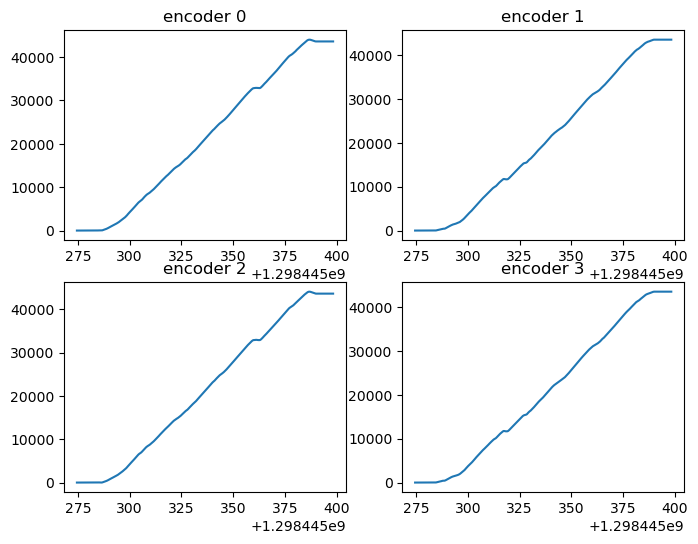

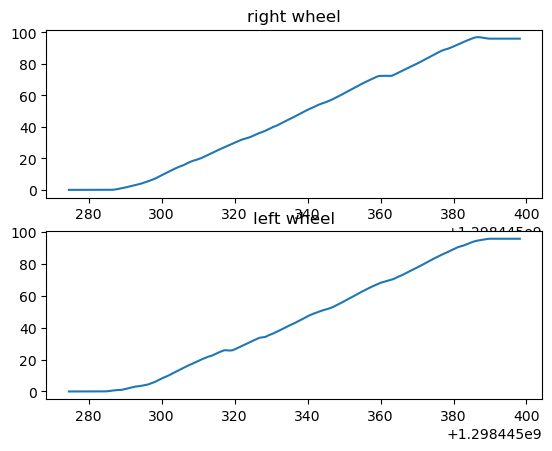

In [306]:
cum_encoder = np.cumsum(encoder_counts,axis=1)
r_avg_whl, l_avg_whl = (cum_encoder[0]+cum_encoder[2])*(0.0022/2), (cum_encoder[1]+cum_encoder[3])*(0.0022/2)

fig, axes = plt.subplots(2, len(cum_encoder)//2, figsize=(8,6))
for i,ax in enumerate(axes.flatten()):
    ax.plot(encoder_stamps,cum_encoder[i])
    ax.set_title(f'encoder {i}')
plt.show()

fig, axes = plt.subplots(2, 1)
for i,ax in enumerate(axes.flatten()):
    ax.plot(encoder_stamps,[r_avg_whl, l_avg_whl][i])
    ax.set_title(f'{["right","left"][i]} wheel')
plt.show()

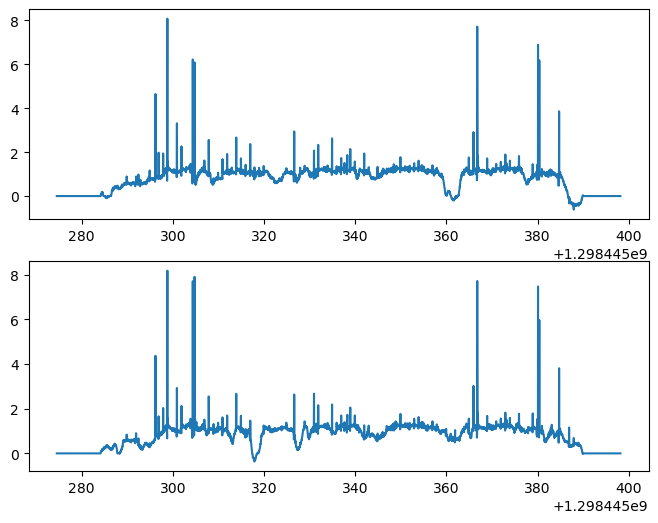

In [308]:
fig, axes = plt.subplots(2, 1, figsize=(8,6))
l_velocity = np.gradient(r_avg_whl,encoder_stamps,edge_order=1)
r_velocity = np.gradient(l_avg_whl,encoder_stamps,edge_order=1)
axes.flatten()[0].plot(encoder_stamps,l_velocity)
axes.flatten()[1].plot(encoder_stamps,r_velocity)


Text(0.5, 1.0, 'Linear Velocity from wheel encoder')

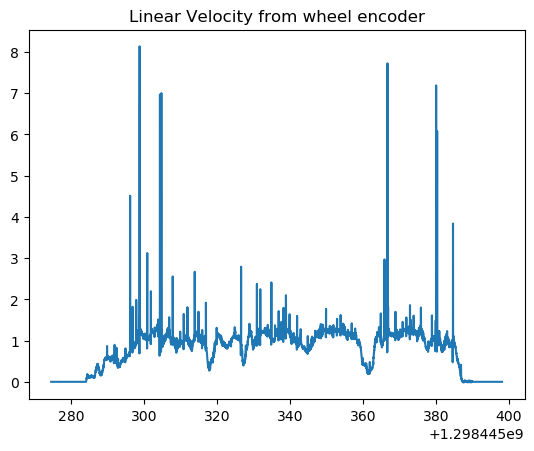

In [309]:
velocity_encoder = (l_velocity+r_velocity)/2
plt.plot(encoder_stamps,velocity_encoder)
plt.title("Linear Velocity from wheel encoder") 

## IMU

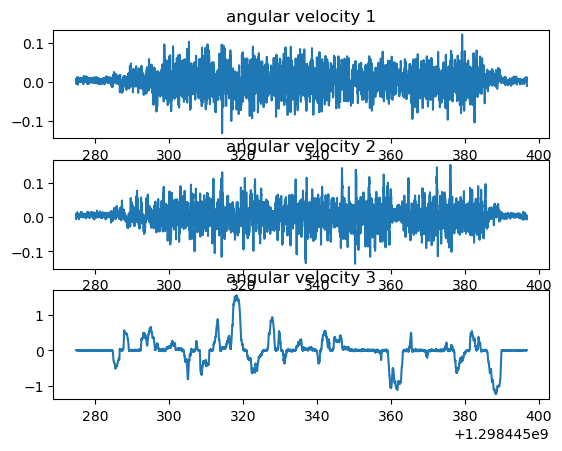

In [14]:
fig, axes = plt.subplots(3, 1)
for i,ax in enumerate(axes.flatten()):
    ax.plot(imu_stamps,imu_angular_velocity[i])
    ax.set_title(f'angular velocity {i+1}')
plt.show()

omega = imu_angular_velocity[2]

## LIDAR

In [140]:
import pr2_utils

In [141]:
lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,6],LIDAR_ANGLES)

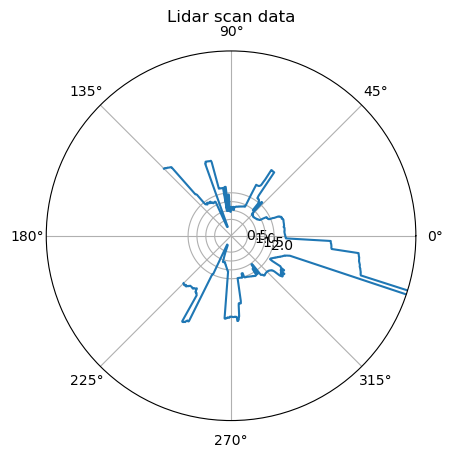

In [142]:
show_lidar(lidar_range_thresh,lidar_angles_thresh)

In [143]:
xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
xis,yis = lidar_polar2cell(lidar_range_thresh,lidar_angles_thresh,MAP)

In [144]:
indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))


In [145]:
MAP['map'][xis[indGood],yis[indGood]] = 1
MAP['map'][xis[indGood],yis[indGood]]

array([1., 1., 1., ..., 1., 1., 1.])

(-4.176443424292016, 11.090289201417496, -4.912994379962062, 4.232398411913316)

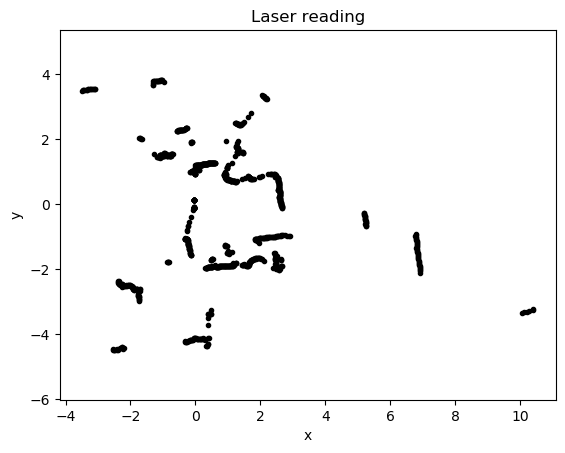

In [146]:
fig1 = plt.figure()
plt.plot(xs0,ys0,'.k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Laser reading")
plt.axis('equal')


Text(0.5, 1.0, 'Occupancy grid map')

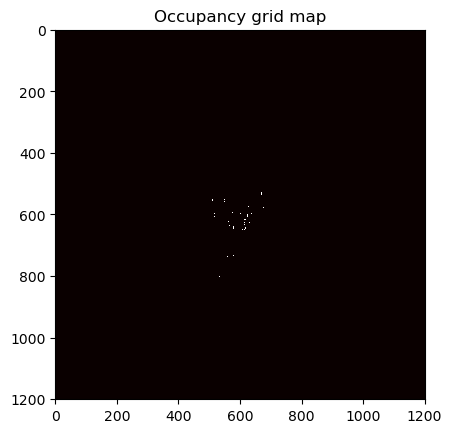

In [147]:
fig2 = plt.figure()
plt.imshow(MAP['map'],cmap="hot");
plt.title("Occupancy grid map")


Testing map_correlation with 801x801 cells
Map Correlation took: 0.0029158592224121094 sec.

...Test passed.


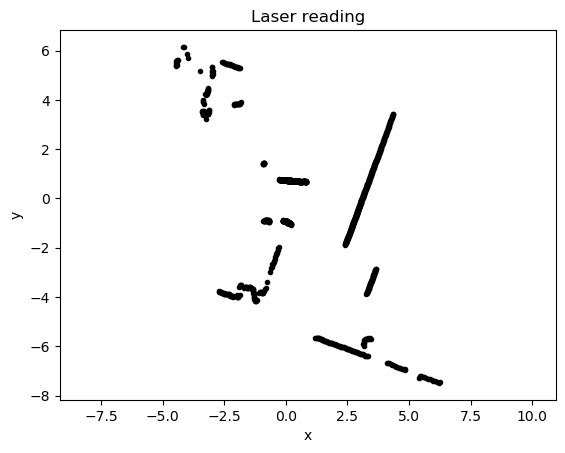

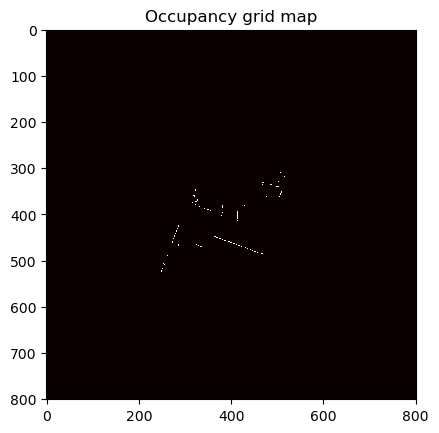

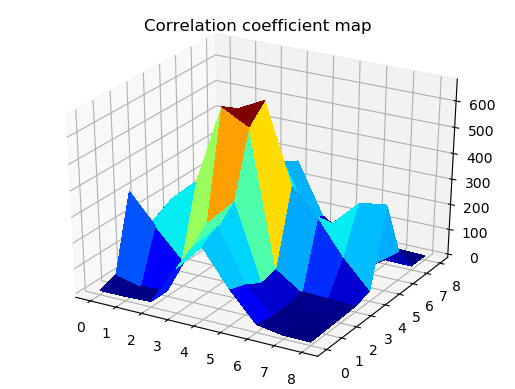

In [148]:
pr2_utils.test_mapCorrelation()


# Map creation


In [15]:
INIT_R = np.eye(3)
INIT_P = np.array([0,0,0]).astype('float')

Text(0.5, 1.0, 'Occupancy grid map')

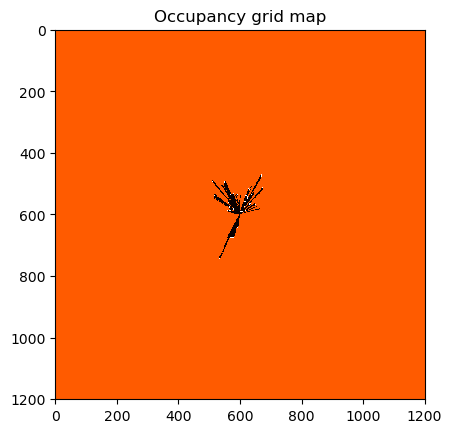

In [18]:
MAP = generate_MAP()
robot_R = INIT_R; robot_p = INIT_P; robot_th = 0;
lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,0],LIDAR_ANGLES)
xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
xs0 = xs0-2.9833 #Conversion from lidar to IMU frame
xs0,ys0,_ = ((robot_R@np.stack((xs0,ys0,np.ones_like(xs0)))).T+robot_p).T
xis,yis = lidar_cart2cell(xs0,ys0,MAP)

bresenham_coords = np.array([[0,0]])
robot_p_cell = lidar_cart2cell(robot_p[0],robot_p[1],MAP)
for xi_i,yi_i in zip(xis,yis):
    bresenham_coords = np.vstack((bresenham_coords,pr2_utils.bresenham2D(robot_p_cell[0],robot_p_cell[1],xi_i,yi_i).T)).astype(int)
    # bresenham_coords.append((pr2_utils.bresenham2D(robot_p[0],robot_p[1],xs_i,ys_i).T))
bresenham_coords = np.unique(bresenham_coords,axis=0)
bresenham_good_ind = clean_indices(bresenham_coords.T[0],bresenham_coords.T[1],MAP)
MAP['map'][bresenham_coords.T[0][bresenham_good_ind],bresenham_coords.T[1][bresenham_good_ind]] = -np.log(4)

indGood = clean_indices(xis,yis,MAP)
MAP['map'][xis[indGood],yis[indGood]] = np.log(4)

fig2 = plt.figure()
plt.imshow(MAP['map'],cmap="hot");
plt.title("Occupancy grid map")


In [19]:
np.stack((xis,yis)).T

array([[492, 552],
       [492, 552],
       [492, 551],
       ...,
       [471, 670],
       [471, 669],
       [470, 669]], dtype=int16)

In [20]:
bresenham_coords

array([[  0,   0],
       [470, 669],
       [471, 668],
       ...,
       [746, 535],
       [747, 534],
       [747, 535]])

# Dead Reackoning

In [21]:
def populateMap(lidar_ranges,LIDAR_ANGLES,lidar_ind,robot_R,robot_p,MAP):
    lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,lidar_ind],LIDAR_ANGLES)
    xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
    xs0 = xs0+0.29833 #Conversion from lidar to IMU frame
    xs0,ys0,_ = ((robot_R@np.stack((xs0,ys0,np.ones_like(xs0)))).T+robot_p).T
    xis,yis = lidar_cart2cell(xs0,ys0,MAP)

    bresenham_coords = np.array([[0,0]])
    robot_p_cell = lidar_cart2cell(robot_p[0],robot_p[1],MAP)
    for xi_i,yi_i in zip(xis,yis):
        bresenham_coords = np.vstack((bresenham_coords,pr2_utils.bresenham2D(robot_p_cell[0],robot_p_cell[1],xi_i,yi_i).T)).astype(int)
        # bresenham_coords.append((pr2_utils.bresenham2D(robot_p[0],robot_p[1],xs_i,ys_i).T))
    # bresenham_coords = np.unique(bresenham_coords,axis=0)
    bresenham_good_ind = clean_indices(bresenham_coords.T[0],bresenham_coords.T[1],MAP)
    MAP['map'][bresenham_coords.T[0][bresenham_good_ind],bresenham_coords.T[1][bresenham_good_ind]]-=np.log(4)

    indGood = clean_indices(xis,yis,MAP)
    MAP['map'][xis[indGood],yis[indGood]] += 2*np.log(4)

    

In [72]:
robot_R = INIT_R; robot_p = INIT_P; robot_th = 0;
MAP = generate_MAP()
trajectory = []
pose_th_his = []

for encoder_ind,(t,dt) in tqdm(enumerate(zip(encoder_stamps[1:],encoder_stamps[1:]-encoder_stamps[:-1])),total=encoder_stamps.shape[0]):
    lidar_ind = np.argmin(np.abs(lidar_stamsp-t))
    imu_ind = np.argmin(np.abs(imu_stamps-t))
    
    dir_vec = np.array([np.cos(robot_th),np.sin(robot_th),0])
    # vs = np.expand_dims(np.random.normal(velocity_imu[encoder_ind],SIGMA_V,N),-1)*dir_vecs
    robot_p=robot_p+(velocity_encoder[encoder_ind]*dt*dir_vec)
    # print(dt)
    trajectory+=[list(robot_p)]
    
    # ws = np.random.normal(omega[imu_ind],SIGMA_W,N)
    robot_th = robot_th+(omega[imu_ind]*dt)
    pose_th_his+=[robot_th]
    
    robot_R = rotationMatrix(robot_th)
    
    populateMap(lidar_ranges,LIDAR_ANGLES,lidar_ind,robot_R,robot_p,MAP)
trajectory = np.array(trajectory)

100%|██████████████████████████████████████▉| 4955/4956 [05:39<00:00, 14.62it/s]


In [155]:
MAP['map']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

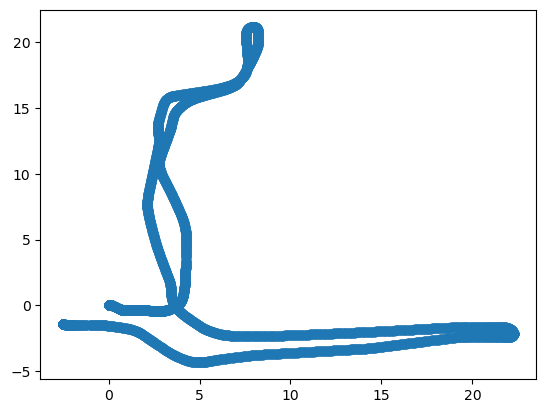

In [73]:
plt.scatter(trajectory[...,0],trajectory[...,1])

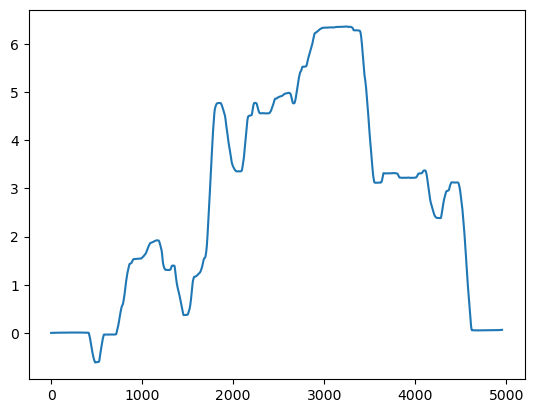

In [74]:
plt.plot(pose_th_his)

/tmp/ipykernel_52044/1511555836.py:69: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


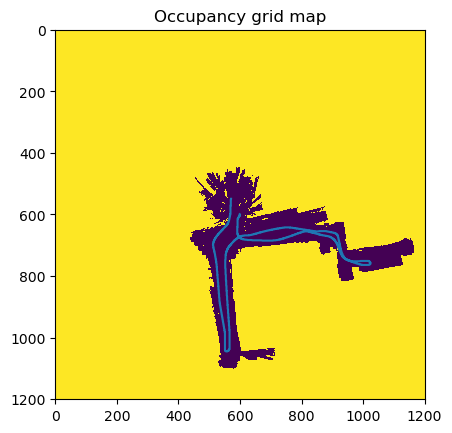

In [289]:
fig2 = plt.figure()
plt.imshow(np.vectorize(sigmoid)(MAP['map'])>0.2);
plt.plot(lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[0],lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[1])
plt.title("Occupancy grid map")
fig2.savefig("./images/test.png")


# Prediction Step

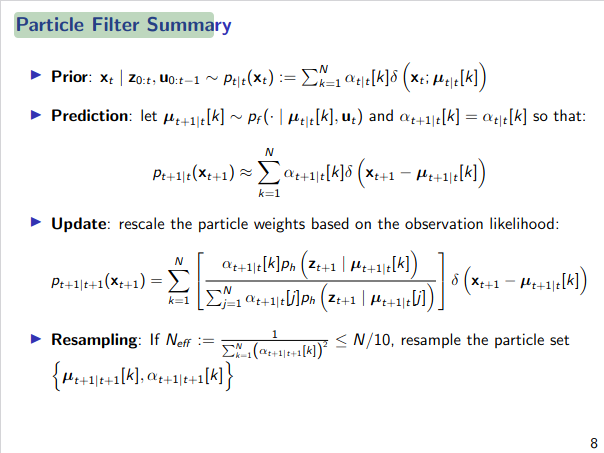

In [ ]:
def mapCorrelation(im, x_im, y_im, vp, xs, ys):
  '''
  INPUT 
  im              the map 
  x_im,y_im       physical x,y positions of the grid map cells
  vp[0:2,:]       occupied x,y positions from range sensor (in physical unit)  
  xs,ys           physical x,y,positions you want to evaluate "correlation" 

  OUTPUT 
  c               sum of the cell values of all the positions hit by range sensor
  '''
    nx = im.shape[0]
    ny = im.shape[1]
    xmin = x_im[0]
    xmax = x_im[-1]
    xresolution = (xmax-xmin)/(nx-1)
    ymin = y_im[0]
    ymax = y_im[-1]
    yresolution = (ymax-ymin)/(ny-1)
    nxs = xs.size
    nys = ys.size
    cpr = np.zeros((nxs, nys))
    for jy in range(0,nys):
        y1 = vp[1,:] + ys[jy] # 1 x 1076
        iy = np.int16(np.round((y1-ymin)/yresolution))
        for jx in range(0,nxs):
            x1 = vp[0,:] + xs[jx] # 1 x 1076
            ix = np.int16(np.round((x1-xmin)/xresolution))
            valid = np.logical_and( np.logical_and((iy >=0), (iy < ny)), \
                                        np.logical_and((ix >=0), (ix < nx)))
            cpr[jx,jy] = np.sum(im[ix[valid],iy[valid]])
    return cpr


In [179]:
def get_correlation(Y,MAP,correlation_grid_size_factor=2):
    
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-correlation_grid_size_factor*MAP['res'],(correlation_grid_size_factor*MAP['res'])+MAP['res'],MAP['res'])
    y_range = np.arange(-correlation_grid_size_factor*MAP['res'],(correlation_grid_size_factor*MAP['res'])+MAP['res'],MAP['res'])
    c = pr2_utils.mapCorrelation(sigmoid_map(MAP['map'])>0.5,x_im,y_im,Y,x_range,y_range)
    x_cmax,y_cmax = np.unravel_index(c.argmax(), c.shape)
    # print(c,x_range[x_cmax],y_range[y_cmax],x_cmax,y_cmax)
    
    return np.max(c),np.array([x_range[x_cmax],y_range[y_cmax],0])


In [348]:
def lidar2world(lidar_ind,robot_R,robot_p):
    lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,lidar_ind],LIDAR_ANGLES)
    xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
    xs0 = xs0+0.29833 #Conversion from lidar to IMU frame
    xs0,ys0,_ = ((robot_R@np.stack((xs0,ys0,np.ones_like(xs0)))).T+robot_p).T
    return xs0,ys0


In [67]:
# def populateMap(lidar_ranges,LIDAR_ANGLES,lidar_ind,robot_R,robot_p,MAP):
#     lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,lidar_ind],LIDAR_ANGLES)
#     xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
#     xs0 = xs0+0.29833 #Conversion from lidar to IMU frame
#     xs0,ys0,_ = ((robot_R@np.stack((xs0,ys0,np.ones_like(xs0)))).T+robot_p).T
#     xis,yis = lidar_cart2cell(xs0,ys0,MAP)

#     bresenham_coords = np.array([[0,0]])
#     robot_p_cell = lidar_cart2cell(robot_p[0],robot_p[1],MAP)
#     for xi_i,yi_i in zip(xis,yis):
#         bresenham_coords = np.vstack((bresenham_coords,pr2_utils.bresenham2D(robot_p_cell[0],robot_p_cell[1],xi_i,yi_i).T)).astype(int)
#         # bresenham_coords.append((pr2_utils.bresenham2D(robot_p[0],robot_p[1],xs_i,ys_i).T))
#     # bresenham_coords = np.unique(bresenham_coords,axis=0)
#     bresenham_good_ind = clean_indices(bresenham_coords.T[0],bresenham_coords.T[1],MAP)
#     MAP['map'][bresenham_coords.T[0][bresenham_good_ind],bresenham_coords.T[1][bresenham_good_ind]]-=np.log(4)

#     indGood = clean_indices(xis,yis,MAP)
#     MAP['map'][xis[indGood],yis[indGood]] += 2*np.log(4)


def populateMap_particle(Y,robot_p,MAP):
#     lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,lidar_ind],LIDAR_ANGLES)
#     xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
#     xs0 = xs0+0.29833 #Conversion from lidar to IMU frame
    xs0,ys0 = Y
    
#     v = get_correlation(xs0,ys0,MAP)
    
    xis,yis = lidar_cart2cell(xs0,ys0,MAP)

    bresenham_coords = np.array([[0,0]])
    robot_p_cell = lidar_cart2cell(robot_p[0],robot_p[1],MAP)
    for xi_i,yi_i in zip(xis,yis):
        bresenham_coords = np.vstack((bresenham_coords,pr2_utils.bresenham2D(robot_p_cell[0],robot_p_cell[1],xi_i,yi_i).T)).astype(int)
        # bresenham_coords.append((pr2_utils.bresenham2D(robot_p[0],robot_p[1],xs_i,ys_i).T))
    # bresenham_coords = np.unique(bresenham_coords,axis=0)
    bresenham_good_ind = clean_indices(bresenham_coords.T[0],bresenham_coords.T[1],MAP)
    MAP['map'][bresenham_coords.T[0][bresenham_good_ind],bresenham_coords.T[1][bresenham_good_ind]]-=np.log(4)

    indGood = clean_indices(xis,yis,MAP)
    MAP['map'][xis[indGood],yis[indGood]] += 2*np.log(4)


In [271]:
N = 5
MAP = generate_MAP()
robot_p = INIT_P;
correlation_grid_size_factor = 1
# robot_p = np.expand_dims(robot_p,0)
robot_ps = np.tile(robot_p,(N,1))
robot_th = np.tile(0,(N))
alphas = np.tile(1/N,(N))
trajectories = []
best_trajectory = []
robot_th_histories = []
best_robot_th = []
for encoder_ind,(t,dt) in tqdm(enumerate(zip(encoder_stamps[1:],encoder_stamps[1:]-encoder_stamps[:-1])),total=encoder_stamps.shape[0]):
    lidar_ind = np.argmin(np.abs(lidar_stamsp-t))
    imu_ind = np.argmin(np.abs(imu_stamps-t))
    
    dir_vecs = np.stack([np.cos(robot_th),np.sin(robot_th),np.zeros_like(robot_th)]).T
    vs = np.expand_dims(np.random.normal(velocity_encoder[encoder_ind],SIGMA_V,N),-1)*dir_vecs
    robot_ps=robot_ps+(vs*dt)
    
    ws = np.random.normal(omega[imu_ind],SIGMA_W,N)
    robot_th = robot_th+(ws*dt)
    
    robot_Rs = np.apply_along_axis(lambda x:rotationMatrix(x[0]),1,np.expand_dims(robot_th,-1))
    
    lidar_range_thresh,lidar_angles_thresh = thresh_lidar(lidar_ranges[...,lidar_ind],LIDAR_ANGLES)
    xs0,ys0 = lidar_polar2cart(lidar_range_thresh,lidar_angles_thresh)
    xs0 = xs0+0.29833 #Conversion from lidar to IMU frame
    Ys = (((robot_Rs)@np.stack((xs0,ys0,np.zeros_like(xs0))))+np.expand_dims(robot_ps,-1))[:,:2,:]
    # corrs = np.apply_along_axis(lambda ysi:get_correlation(Ys[ysi[0]],MAP,correlation_grid_size_factor),1,np.expand_dims(np.arange(N),1))
    cs = [];delta_ps = [];
    for ni,Y in enumerate(Ys):
        c, delta_p = get_correlation(Y,MAP,correlation_grid_size_factor)
        # c = 1
        # print(c)
        alphas[ni]*=(c+1e-6)
        cs+=[c]
        delta_ps+=[delta_p]
    alphas = alphas/np.sum(alphas)
    alpha_ind = np.argmax(alphas)
    

    populateMap_particle(Ys[alpha_ind],robot_ps[alpha_ind],MAP)
    # populateMap(lidar_ranges,LIDAR_ANGLES,lidar_ind,robot_Rs[alpha_ind],robot_ps[alpha_ind],MAP)
    
    trajectories+=[robot_ps]
    robot_th_histories += [robot_th]
    best_trajectory+=[robot_ps[alpha_ind]]
    best_robot_th+=[robot_th[alpha_ind]]
    
    # robot_ps[np.array(cs)>0]+=np.array(delta_ps)[np.array(cs)>0]
    n_eff = 1/np.sum(alphas**2)
    if(n_eff<(N/30)):
        print("refactoring")
        robot_ps = robot_ps[np.random.choice(np.arange(N),size=N,p=alphas)]
        robot_th = robot_th[np.random.choice(np.arange(N),size=N,p=alphas)]
        alphas = np.tile(1/N,(N))
    # print(encoder_ind)
#     if((encoder_ind+1)%200==0):
#         plt.imshow(np.vectorize(sigmoid)(MAP['map'])>0.2);
#         # plt.plot(lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[0],lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[1])
#         plt.title("Occupancy grid map")
#         plt.show()
            


 11%|████▍                                   | 547/4956 [00:59<07:44,  9.50it/s]/tmp/ipykernel_52044/1511555836.py:72: RuntimeWarning: overflow encountered in exp
  return np.exp(m) / (1 + np.exp(m))
/tmp/ipykernel_52044/1511555836.py:72: RuntimeWarning: invalid value encountered in divide
  return np.exp(m) / (1 + np.exp(m))
100%|██████████████████████████████████████▉| 4955/4956 [09:02<00:00,  9.14it/s]


/tmp/ipykernel_52044/1511555836.py:69: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Text(0.5, 1.0, 'Occupancy grid map')

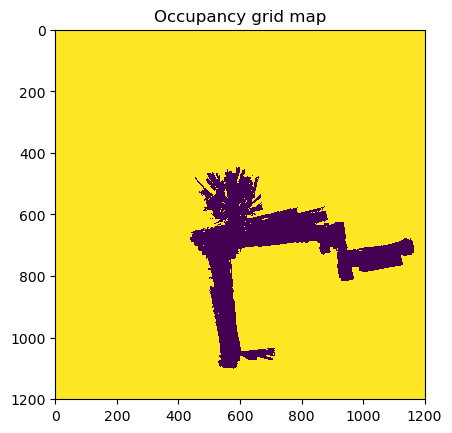

In [272]:
fig2 = plt.figure()
plt.imshow(np.vectorize(sigmoid)(MAP['map'])>0.2);
# plt.plot(lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[0],lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[1])
plt.title("Occupancy grid map")


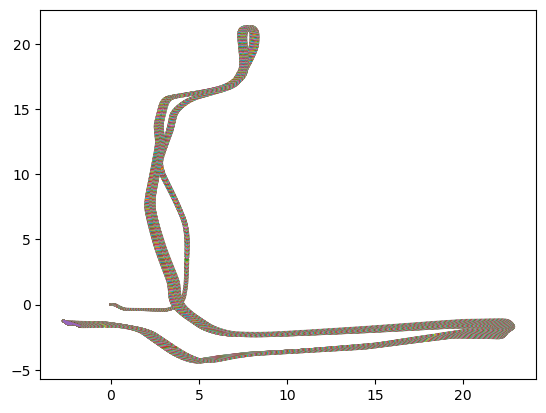

In [273]:
        # bresenham_coords.append((pr2_utils.bresenham2D(robot_p[0],robot_p[1],xs_i,ys_i).T))
    # bresenham_coords = np.unique(bresenham_coords,axis=0)


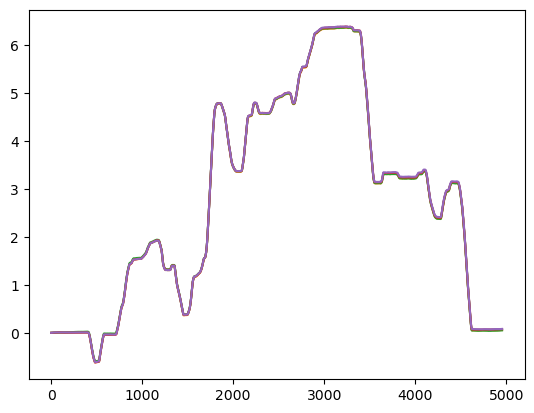

In [274]:
for i in range(N):
    plt.plot(np.array(robot_th_histories)[:,i])

# Texture Map

(480, 640, 3)


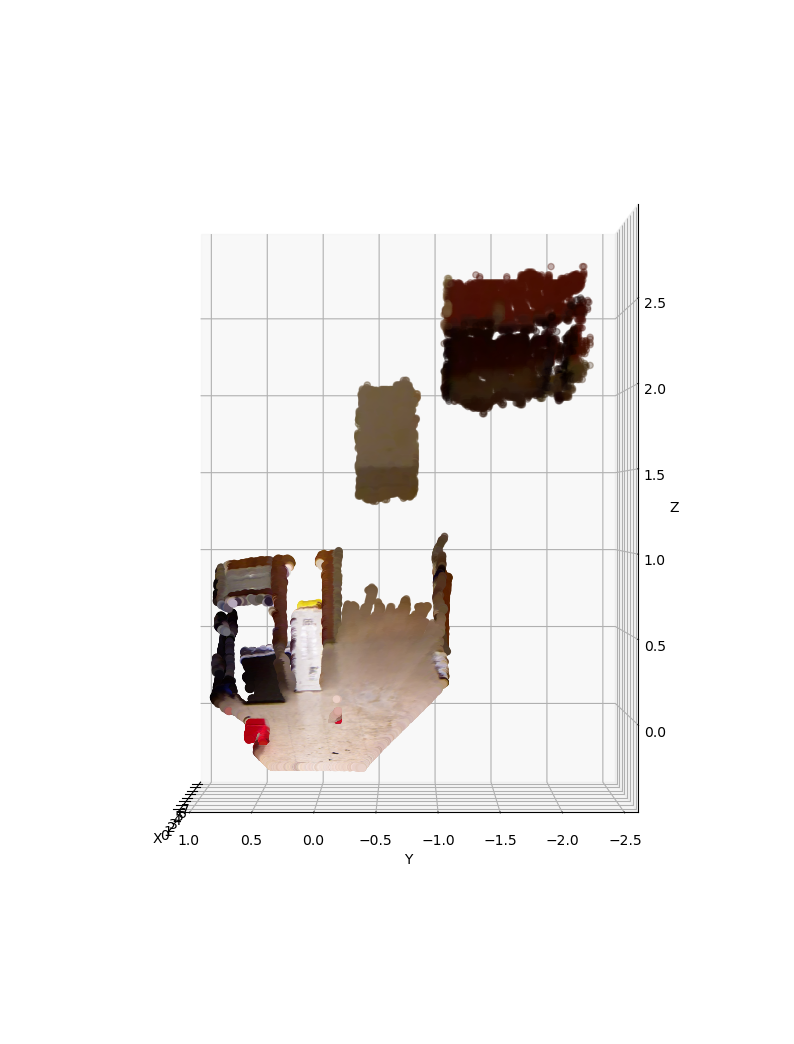

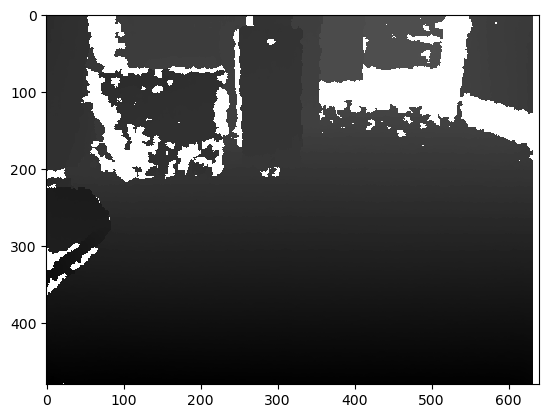

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "../data/dataRGBD/Disparity20/"
rgb_path = "../data/dataRGBD/RGB20/"

def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_-min_)

# load RGBD image
imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

print(imc.shape)

# convert from disparity from uint16 to double
disparity = imd.astype(np.float32)

# get depth
dd = (-0.00304 * disparity + 3.31)
z = 1.03 / dd

# calculate u and v coordinates 
v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
#u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

# get 3D coordinates 
fx = 585.05108211
fy = 585.05108211
cx = 315.83800193
cy = 242.94140713
x = (u-cx) / fx * z
y = (v-cy) / fy * z

# calculate the location of each pixel in the RGB image
rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
rgbv = np.round((v * 526.37 + 16662.0)/fy)
valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

# display valid RGB pixels
fig = plt.figure(figsize=(10, 13.3))
ax = fig.add_subplot(projection='3d')
ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=180)
plt.show()

# display disparity image
plt.imshow(normalize(imd), cmap='gray')
plt.show()

In [203]:
(imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0).shape

(303305, 3)

In [196]:
x[valid].shape

(303305,)

In [275]:
R_cam = np.array([[0.92,-0.2,0.35],[ 0.21,0.98,  0],[-0.34,0.07, 0.94]])
p_cam = np.array([0.18, 0.005, 0.36])

def get_texture(disp_ind,rgb_ind):
    imd = cv2.imread(disp_path+f'disparity20_{disp_ind+1}.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
    imc = cv2.imread(rgb_path+f'rgb20_{rgb_ind+1}.png')[...,::-1] # (480 x 640 x 3)

    # print(imc.shape)

    # convert from disparity from uint16 to double
    disparity = imd.astype(np.float32)

    # get depth
    dd = (-0.00304 * disparity + 3.31)
    z = 1.03 / dd

    # calculate u and v coordinates 
    v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
    #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

    # get 3D coordinates 
    fx = 585.05108211
    fy = 585.05108211
    cx = 315.83800193
    cy = 242.94140713
    x = (u-cx) / fx * z
    y = (v-cy) / fy * z

    # calculate the location of each pixel in the RGB image
    rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
    rgbv = np.round((v * 526.37 + 16662.0)/fy)
    valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])
    
    return np.stack((z[valid],-x[valid],-y[valid])), (imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)



In [213]:
np.array(best_trajectory)

array([[-3.37525684e-03,  0.00000000e+00,  0.00000000e+00],
       [ 4.67915356e-03, -1.07763129e-07,  0.00000000e+00],
       [-6.12926988e-03,  4.78891146e-07,  0.00000000e+00],
       ...,
       [-2.50851801e+00, -1.45771218e+00,  0.00000000e+00],
       [-2.50596432e+00, -1.45757882e+00,  0.00000000e+00],
       [-2.50771028e+00, -1.45767115e+00,  0.00000000e+00]])

In [304]:
N = 5
# MAP = generate_MAP()
robot_p = INIT_P;
correlation_grid_size_factor = 1
# robot_p = np.expand_dims(robot_p,0)
robot_ps = np.tile(robot_p,(N,1))
robot_th = np.tile(0,(N))
alphas = np.tile(1/N,(N))
trajectories = []
robot_th_histories = []

R_cam = np.array([[0.92,-0.2,0.35],[ 0.21,0.98,  0],[-0.34,0.07, 0.94]])
p_cam = np.array([0.18, 0.005, 0.36])
MAP['texture'] = np.zeros(list(MAP['map'].shape)+[3])

for encoder_ind,(t,dt) in tqdm(enumerate(zip(encoder_stamps[1:],encoder_stamps[1:]-encoder_stamps[:-1])),total=encoder_stamps.shape[0]):
    lidar_ind = np.argmin(np.abs(lidar_stamsp-t))
    imu_ind = np.argmin(np.abs(imu_stamps-t))
    rgb_ind = np.argmin(np.abs(rgb_stamps-t))
    disp_ind = np.argmin(np.abs(disp_stamps-t))
    
    texture_ps,texture_cs = get_texture(disp_ind,rgb_ind)
    texture_ps_body = ((R_cam@texture_ps)+np.expand_dims(p_cam,-1))
    xps,yps,zps = ((rotationMatrix(best_robot_th[encoder_ind])@texture_ps_body)+np.expand_dims(best_trajectory[encoder_ind],-1))
    
    
    on_ground_ind = zps<0.127
    xps = xps[on_ground_ind]
    yps = yps[on_ground_ind]
    texture_cs_g = texture_cs[on_ground_ind]
    
    xps_cell,yps_cell = lidar_cart2cell(xps,yps,MAP)
    clean_ind = clean_indices(xps_cell,yps_cell,MAP)
    
    MAP['texture'][xps_cell[clean_ind],yps_cell[clean_ind]] = texture_cs_g[clean_ind]
    
    # MAP['texture'][xps,yps]
    
    
    
    
    # # print(encoder_ind)
    # if((encoder_ind+1)%200==0):
    #     plt.imshow(np.vectorize(sigmoid)(MAP['map'])>0.2);
    #     # plt.plot(lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[0],lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[1])
    #     plt.title("Occupancy grid map")
    #     plt.show()
            


100%|██████████████████████████████████████▉| 4955/4956 [08:55<00:00,  9.25it/s]


In [300]:
MAP['texture']*np.expand_dims(MAP['map']>0.2,-1)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

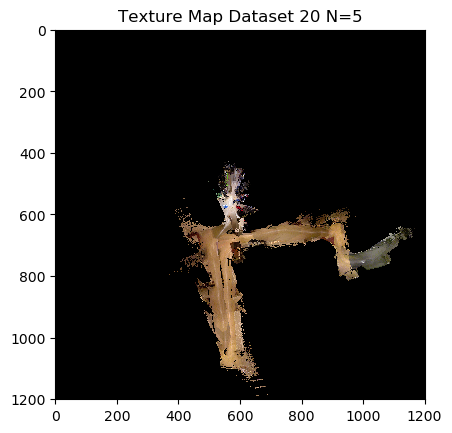

In [305]:
fig4 = plt.figure()
# MAP['texture'][MAP['map']==0.5]=0
plt.imshow(MAP['texture']*np.expand_dims(MAP['map']<0.2,-1));
# plt.plot(lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[0],lidar_cart2cell(trajectory[...,1],trajectory[...,0],MAP)[1])
plt.title(f'Texture Map Dataset {dataset} N={N}')
fig4.savefig(f'./images/TextureMap_{N}_particles_{dataset}.png')


In [284]:
MAP['texture'][MAP['map']>0.2]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [265]:
480 * 640

307200

In [267]:
np.ix_(xps_cell,yps_cell)

(array([[757],
        [757],
        [757],
        ...,
        [615],
        [615],
        [615]], dtype=int16),
 array([[585, 585, 584, ..., 595, 595, 595]], dtype=int16))

In [303]:
import pickle
with open('./images/MAP_d20_N_5.pickle', 'rb') as handle:
    MAP = pickle.load(handle)
